# Health Outcomes Analysis – Individual Assignment (Part 1+Part 2)

In this notebook I work as a junior data analyst at a research institute.  
The task is to analyse a health-related dataset and answer a set of basic statistical questions using Python.

The goals are to:

- describe the data using simple summary statistics,
- create visualisations of important variables,
- run a simple simulation related to disease status,
- compute a 95% confidence interval for the mean systolic blood pressure using a normal approximation,
- also compute a bootstrap confidence interval for the same mean and compare the two methods,
- test a hypothesis about smokers and non-smokers using a t-test,
- run a small simulation study to estimate the power of the hypothesis test.
- refactor parts of the analysis into reusable functions and a small HealthAnalyzer class in src/health_analysis.py,
- fit simple and multiple linear regression models for systolic blood pressure using age and weight as predictors, and visualise the model fit

All analysis is self-contained in this notebook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from src.health_analysis import HealthAnalyzer

# Make plots appear inside the notebook
%matplotlib inline


In [ ]:
# Load the dataset from the data folder
df = pd.read_csv("data/health_study_dataset.csv")

# Show the first rows
df.head()

analyzer = HealthAnalyzer(df)


In [3]:
# Basic information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


In [4]:
# Summary statistics for numeric variables
df.describe()


,id,age,height,weight,systolic_bp,cholesterol,disease
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,49.426250,171.849250,73.413000,149.178625,4.929150,0.058750
std,231.0844,14.501118,9.804259,13.685059,12.793360,0.848413,0.235303
min,1.0000,18.000000,144.400000,33.700000,106.800000,2.500000,0.000000
25%,200.7500,39.000000,164.775000,64.800000,140.900000,4.327500,0.000000
50%,400.5000,50.000000,171.350000,73.200000,149.400000,4.970000,0.000000
75%,600.2500,59.000000,178.925000,82.600000,157.600000,5.482500,0.000000
max,800.0000,90.000000,200.400000,114.400000,185.900000,7.880000,1.000000


## Data overview

The dataset contains individual-level information about 800 participants in a health study.

The main variables are:

- `age` – age in years
- `sex` – sex (M/F)
- `height` – height in centimetres
- `weight` – weight in kilograms
- `systolic_bp` – systolic blood pressure (mmHg)
- `cholesterol` – cholesterol level (mmol/L)
- `smoker` – smoking status (Yes/No)
- `disease` – indicator for a certain disease (0 = no, 1 = yes)

The summary statistics above give a first impression of typical values and ranges for the numeric variables.


## Descriptive statistics

Next, I calculate mean, median, minimum and maximum for a selection of key health variables.

In [5]:
desc_table = analyzer.basic_stats()
desc_table


,mean,median,min,max
age,49.426250,50.00,18.0,90.00
height,171.849250,171.35,144.4,200.40
weight,73.413000,73.20,33.7,114.40
systolic_bp,149.178625,149.40,106.8,185.90
cholesterol,4.929150,4.97,2.5,7.88


The table above shows mean, median, minimum and maximum for age, height, weight, systolic blood pressure and cholesterol.

## Visualisations

I now create three simple plots to explore the distributions and some relationships in the data.

### 1. Distribution of systolic blood pressure

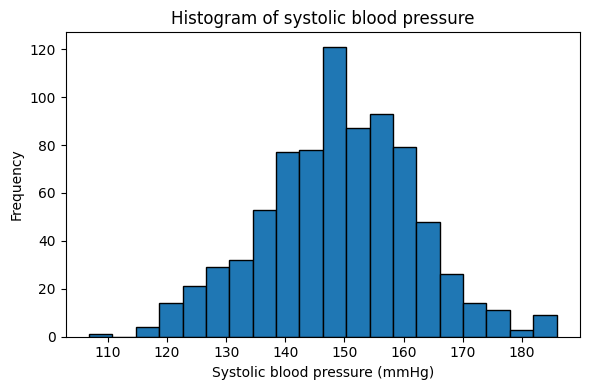

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(df["systolic_bp"].dropna(), bins=20, edgecolor="black")
plt.xlabel("Systolic blood pressure (mmHg)")
plt.ylabel("Frequency")
plt.title("Histogram of systolic blood pressure")
plt.tight_layout()
plt.show()


### 2. Weight by sex (boxplot)

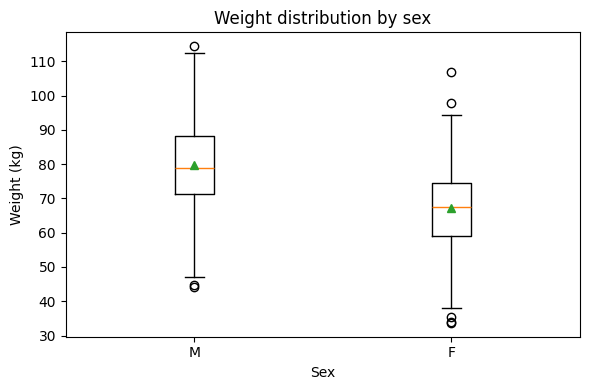

In [7]:
# Prepare data for a simple boxplot by sex
weights_m = df.loc[df["sex"] == "M", "weight"].dropna()
weights_f = df.loc[df["sex"] == "F", "weight"].dropna()

plt.figure(figsize=(6, 4))
plt.boxplot([weights_m, weights_f],
            tick_labels=["M", "F"],
            showmeans=True)
plt.xlabel("Sex")
plt.ylabel("Weight (kg)")
plt.title("Weight distribution by sex")
plt.tight_layout()
plt.show()


### 3. Proportion of smokers

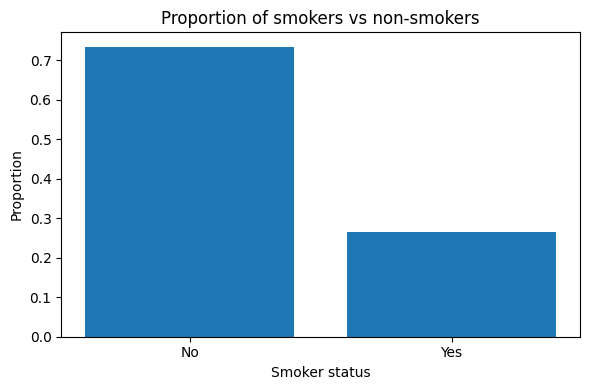

smoker
No     0.73375
Yes    0.26625
Name: proportion, dtype: float64

In [8]:
smoker_counts = df["smoker"].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
plt.bar(smoker_counts.index, smoker_counts.values)
plt.xlabel("Smoker status")
plt.ylabel("Proportion")
plt.title("Proportion of smokers vs non-smokers")
plt.tight_layout()
plt.show()

smoker_counts


The three plots give a simple visual overview of the distribution of blood pressure,
differences in weight between men and women, and the proportion of smokers.

## Linear regression: blood pressure and age

In this section I fit a simple linear regression model for systolic blood pressure using age as predictor.
This uses a vector of ages as input and returns a fitted line that summarises the trend.


In [9]:
model = analyzer.fit_bp_age_regression()

model.coef_[0], model.intercept_


(np.float64(0.5360255996690306), np.float64(122.68488970435858))

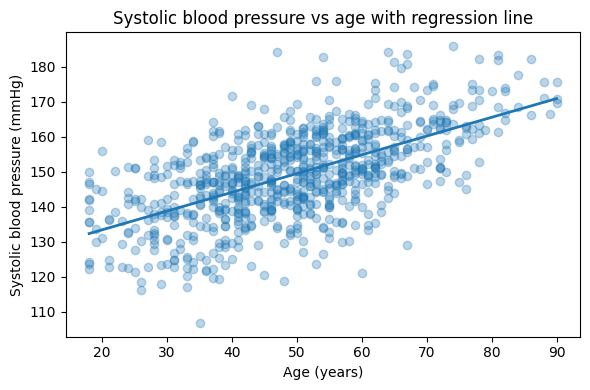

In [10]:
ages = df["age"].values.reshape(-1, 1)
bp_actual = df["systolic_bp"].values
bp_pred = model.predict(ages)

order = np.argsort(ages[:, 0])
ages_sorted = ages[order]
bp_pred_sorted = bp_pred[order]

plt.figure(figsize=(6, 4))
plt.scatter(ages, bp_actual, alpha=0.3)
plt.plot(ages_sorted, bp_pred_sorted, linewidth=2)
plt.xlabel("Age (years)")
plt.ylabel("Systolic blood pressure (mmHg)")
plt.title("Systolic blood pressure vs age with regression line")
plt.tight_layout()
plt.show()


The scatter plot shows the relationship between age and systolic blood pressure.
The fitted regression line summarises the overall trend: the estimated slope is given by the
coefficient printed above. A positive slope means that higher age is associated with higher
mean systolic blood pressure in this sample.


## Multiple linear regression: blood pressure, age and weight

To capture more of the variation in systolic blood pressure, I also fit a multiple linear regression
model that uses both age and weight as predictors. This is a direct extension of the simple regression
and uses a matrix of predictors (one column for age and one for weight) instead of a single vector.


In [11]:
model_multi = analyzer.fit_bp_age_weight_regression()

X_multi = df[["age", "weight"]].values
y_multi = df["systolic_bp"].values

coef_age, coef_weight = model_multi.coef_
intercept_multi = model_multi.intercept_
r2_multi = model_multi.score(X_multi, y_multi)

coef_age, coef_weight, intercept_multi, r2_multi


(np.float64(0.5389276325169825),
 np.float64(0.17765752193267906),
 np.float64(109.49908144566373),
 0.4052560814611623)

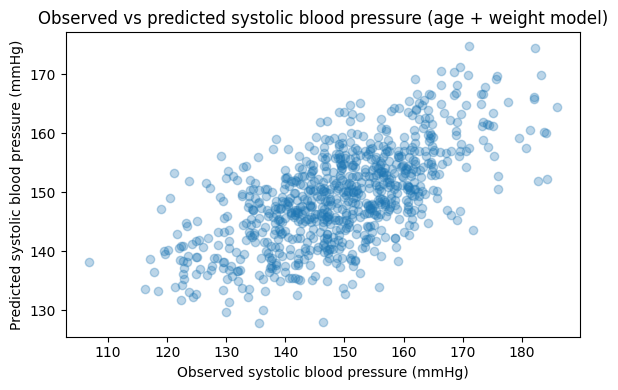

In [12]:
bp_pred_multi = model_multi.predict(X_multi)

plt.figure(figsize=(6, 4))
plt.scatter(y_multi, bp_pred_multi, alpha=0.3)
plt.xlabel("Observed systolic blood pressure (mmHg)")
plt.ylabel("Predicted systolic blood pressure (mmHg)")
plt.title("Observed vs predicted systolic blood pressure (age + weight model)")
plt.tight_layout()
plt.show()


The multiple regression model uses both age and weight to predict systolic blood pressure.
The printed coefficients show how the mean blood pressure changes with one unit increase in age
or weight when the other variable is held fixed.

The R² value indicates how much of the variation in systolic blood pressure is explained by
age and weight together. The plot of observed vs predicted values gives a visual impression
of how well the model fits the data: points close to the diagonal line mean good agreement.


## Simulation based on disease probability

In this step I use the observed proportion of disease in the dataset to simulate new individuals  
with the same probability of having the disease.


In [13]:
# Since disease is coded as 0/1, the mean is the proportion with disease
p_disease = df["disease"].mean()
p_disease


np.float64(0.05875)

In [14]:
np.random.seed(42)  # for reproducibility

n_sim = 1000
simulated_disease = np.random.binomial(n=1, p=p_disease, size=n_sim)

simulated_proportion = simulated_disease.mean()
simulated_proportion


np.float64(0.056)

The true proportion of disease in the original dataset is given by `p_disease`  
and the simulated proportion in 1000 new individuals is given by `simulated_proportion`.

The two values are not exactly the same, but they are reasonably close.  
This is expected when we simulate a random sample of this size from the same probability.


## Confidence interval for mean systolic blood pressure

Next, I construct a 95% confidence interval for the mean of `systolic_bp`  
using a normal approximation.

In [15]:
bp = df["systolic_bp"].dropna()

mean_bp = bp.mean()
std_bp = bp.std(ddof=1)
n_bp = bp.shape[0]

alpha = 0.05
z_value = stats.norm.ppf(1 - alpha/2)  # ≈ 1.96 for 95% CI

margin_of_error = z_value * std_bp / np.sqrt(n_bp)

ci_lower = mean_bp - margin_of_error
ci_upper = mean_bp + margin_of_error

mean_bp, ci_lower, ci_upper


(np.float64(149.178625),
 np.float64(148.2921066505355),
 np.float64(150.06514334946453))

### Alternative confidence interval using bootstrap

To compare with the normal approximation, I also calculate a 95% confidence interval
for the mean of `systolic_bp` using a simple bootstrap method.

The idea is to resample the observed blood pressure values with replacement many times. Then for each resample, calculate the mean and then use the 2.5% and 97.5% percentiles of the bootstrap means as the interval.


In [16]:
# Bootstrap 95% confidence interval for mean systolic blood pressure

bp_values = df["systolic_bp"].dropna().values
n_bp = len(bp_values)

np.random.seed(42)   # for reproducibility
B = 2000             # number of bootstrap samples

bootstrap_means = []

for i in range(B):
    sample = np.random.choice(bp_values, size=n_bp, replace=True)
    bootstrap_means.append(sample.mean())

boot_lower = np.percentile(bootstrap_means, 2.5)
boot_upper = np.percentile(bootstrap_means, 97.5)

boot_lower, boot_upper


(np.float64(148.30968124999998), np.float64(150.100565625))

The bootstrap interval is based on the variation in the resampled means.

Now I have two 95% confidence intervals for the mean systolic blood pressure:

- Normal approximation: from `ci_lower` to `ci_upper`.
- Bootstrap interval: from `boot_lower` to `boot_upper`.

In this dataset the two intervals are fairly similar, which suggests that the normal approximation works reasonably well here.


## Hypothesis test: smokers vs non-smokers

I now test whether smokers have a higher mean systolic blood pressure than non-smokers.

- Null hypothesis (H0): Smokers and non-smokers have the same mean systolic blood pressure.
- Alternative hypothesis (H1): Smokers have a higher mean systolic blood pressure than non-smokers.

I use an independent samples t-test.


In [17]:
bp_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"].dropna()
bp_nonsmokers = df.loc[df["smoker"] == "No", "systolic_bp"].dropna()

bp_smokers.mean(), bp_nonsmokers.mean()


(np.float64(149.524882629108), np.float64(149.05298126064736))

In [18]:
t_stat, p_value_two_sided = stats.ttest_ind(
    bp_smokers,
    bp_nonsmokers,
    equal_var=False
)

t_stat, p_value_two_sided


(np.float64(0.4503433193393224), np.float64(0.6527338743398998))

In [19]:
# Convert to a one-sided p-value for the hypothesis "smokers > non-smokers"
if bp_smokers.mean() > bp_nonsmokers.mean():
    p_value_one_sided = p_value_two_sided / 2
else:
    p_value_one_sided = 1 - p_value_two_sided / 2

p_value_one_sided


np.float64(0.3263669371699499)

The mean systolic blood pressure is calculated separately for smokers and non-smokers,  
and an independent samples t-test is used to compare the two groups.

The one-sided p-value (printed above) tells us how compatible the data are with the null hypothesis.

- If the p-value is **below 0.05**, there is evidence that smokers tend to have a higher  
  mean systolic blood pressure than non-smokers in this sample.
- If the p-value is **above 0.05**, the data do not provide strong enough evidence  
  to claim a higher mean for smokers.

In this sample the one-sided p-value is about 0.33, which is clearly above 0.05.  
Therefore I do not reject the null hypothesis.

The data do not provide strong enough evidence to conclude that smokers have a higher
mean systolic blood pressure than non-smokers in this study, even if the sample means
may differ somewhat.


## Power simulation for the t-test

To see how often the t-test would be able to detect a real difference,
I run a small simulation (power analysis).

Idea:

- Use the observed means and standard deviations for smokers and non-smokers as an approximation of the "true" values.
- Simulate many new datasets with the same sample sizes as in this study.
- For each simulated dataset, run the same t-test as before.
- Count how often the one-sided p-value is below 0.05.


In [20]:
# Use the current sample statistics as "true" parameters for the simulation

bp_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"].dropna()
bp_nonsmokers = df.loc[df["smoker"] == "No", "systolic_bp"].dropna()

n_smokers = len(bp_smokers)
n_nonsmokers = len(bp_nonsmokers)

mean_smokers = bp_smokers.mean()
mean_nonsmokers = bp_nonsmokers.mean()

std_smokers = bp_smokers.std(ddof=1)
std_nonsmokers = bp_nonsmokers.std(ddof=1)

n_smokers, n_nonsmokers, mean_smokers, mean_nonsmokers


(213, 587, np.float64(149.524882629108), np.float64(149.05298126064736))

In [21]:
np.random.seed(123)

n_sim = 1000          # number of simulated "studies"
alpha = 0.05
count_significant = 0

for i in range(n_sim):
    # simulate new samples for smokers and non-smokers
    sim_smokers = np.random.normal(loc=mean_smokers,
                                   scale=std_smokers,
                                   size=n_smokers)
    sim_nonsmokers = np.random.normal(loc=mean_nonsmokers,
                                      scale=std_nonsmokers,
                                      size=n_nonsmokers)
    
    # two-sided t-test
    t_stat, p_two_sided = stats.ttest_ind(
        sim_smokers,
        sim_nonsmokers,
        equal_var=False
    )
    
    # one-sided p-value for "smokers > non-smokers"
    if sim_smokers.mean() > sim_nonsmokers.mean():
        p_one_sided = p_two_sided / 2
    else:
        p_one_sided = 1 - p_two_sided / 2
    
    if p_one_sided < alpha:
        count_significant += 1

power_estimate = count_significant / n_sim
power_estimate


0.137

In this case the estimated power is around 0.14 (14%).  
This means that if the same study were repeated many times under similar conditions,
the test would only detect the difference in mean blood pressure in about 14% of the studies.
In other words, the test has quite low power in this setting.


## Summary

In this notebook I have:

- explored a health dataset with basic descriptive statistics,
- created three visualisations (distribution of blood pressure, weight by sex, proportion of smokers),
- performed a simple simulation using the observed disease proportion,
- constructed a 95% confidence interval for mean systolic blood pressure,
- computed a bootstrap confidence interval for the same mean and compared the two methods
- tested whether smokers have a higher mean systolic blood pressure than non-smokers.
- carried out a small simulation study to estimate the power of this test under conditions similar to the dataset.
- refactored the analysis by moving some logic into a small HealthAnalyzer class in src/health_analysis.py.
- fitted simple and multiple linear regression models for systolic blood pressure (using age alone and age plus weight) and visualised how well the models fit the data.

## Sources

- Course lecture notes and videos in statistics and Python.
- (https://acclab.github.io/bootstrap-confidence-intervals.html)
- (https://www.stathelp.se/sv/ttest_sv.html)
- Official documentation for pandas, NumPy and Matplotlib.
- Scikit-learn documentation for LinearRegression.
